In [273]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pa
import h5py
import sys
import io
import time
import matplotlib.pyplot as plt

# Start measuring time.
startTime = time.time()

# New API
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.1.153:7077") \
        .appName("Team 01 Georgios Nentidis Final Project")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",7)\
        .getOrCreate()

# Old API (RDD)
spark_context = spark_session.sparkContext


In [274]:
#########################################################
# Load HDF5 files and create a DataFrame out of them
#########################################################

def f(x):
    
    # x[0] = filename
    # x[1] = binary content
    with h5py.File(io.BytesIO(x[1])) as f:

        # Convert all data into Python data types.
        artistName          = f['metadata']['songs']['artist_name'][0].decode('UTF-8')
        artistFamiliarity   = f['metadata']['songs']['artist_familiarity'][0].item()
        artistHottness      = f['metadata']['songs']['artist_hotttnesss'][0].item()
        artistLatitude      = f['metadata']['songs']['artist_latitude'][0].item()
        artistLongitude     = f['metadata']['songs']['artist_longitude'][0].item()
        artistLocation      = f['metadata']['songs']['artist_location'][0].decode('UTF-8')
        songHotttnesss      = f['metadata']['songs']['song_hotttnesss'][0].item()
        title               = f['metadata']['songs']['title'][0].decode('UTF-8')
        ##artist_terms        = fh5.root.metadata.songs.cols.artist_terms
        ##artist_terms_freq   = fh5.root.metadata.songs.cols.artist_terms_freq
        ##artist_terms_weight = fh5.root.metadata.songs.cols.artist_terms_weight
        songId              = f['metadata']['songs']['song_id'][0].decode('UTF-8')
        danceability        = f['analysis']['songs']['danceability'][0].item()
        duration            = f['analysis']['songs']['duration'][0].item()
        energy              = f['analysis']['songs']['energy'][0].item()
        key                 = f['analysis']['songs']['key'][0].item()
        loudness            = f['analysis']['songs']['loudness'][0].item()
        mode                = f['analysis']['songs']['mode'][0].item()
        tempo               = f['analysis']['songs']['tempo'][0].item()
        year                = f['musicbrainz']['songs']['year'][0].item()
    
    return [artistName, artistFamiliarity, artistHottness, artistLatitude, artistLongitude, artistLocation, 
            songHotttnesss, title, songId, danceability, duration, energy, 
            key, loudness, mode, tempo, year]

# Load files, convert and collect them
#rdd = spark_context.binaryFiles("/mnt/ms/data/A/A/*/*,/mnt/ms/data/A/B/*/*,/mnt/ms/data/A/C/*/*,/mnt/ms/data/B/A/*/*,/mnt/ms/data/C/A/*/*,/mnt/ms/data/D/A/*/*,/mnt/ms/data/E/A/*/*,/mnt/ms/data/F/A/*/*")
rdd = spark_context.binaryFiles("/mnt/ms/data/A/*/*/*,/mnt/ms/data/B/*/*/*,/mnt/ms/data/C/*/*/*")
rdd = rdd.map(f)
rdd.collect()

# Conver the RDD into a DataFrame. We need DataFrames for playing with the data and for the Classifiers
fields = [StructField("artistName", StringType(), True), StructField("artistFamiliarity", FloatType(), True),
         StructField("artistHottness", FloatType(), True), StructField("artistLatitude", FloatType(), True),
         StructField("artistLongitude", FloatType(), True), StructField("artistLocation", StringType(), True),
         StructField("songHotttnesss", FloatType(), True), StructField("title", StringType(), True),
         StructField("songId", StringType(), True), StructField("danceability", FloatType(), True),
         StructField("duration", FloatType(), True), StructField("energy", FloatType(), True),
         StructField("key", IntegerType(), True), StructField("loudness", FloatType(), True),
         StructField("mode", IntegerType(), True), StructField("tempo", FloatType(), True),
         StructField("year", IntegerType(), True)]
schema = StructType(fields)

# Apply the schema to the RDD.
songs = spark_session.createDataFrame(rdd, schema)
songs.printSchema()
songs.show()

root
 |-- artistName: string (nullable = true)
 |-- artistFamiliarity: float (nullable = true)
 |-- artistHottness: float (nullable = true)
 |-- artistLatitude: float (nullable = true)
 |-- artistLongitude: float (nullable = true)
 |-- artistLocation: string (nullable = true)
 |-- songHotttnesss: float (nullable = true)
 |-- title: string (nullable = true)
 |-- songId: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- tempo: float (nullable = true)
 |-- year: integer (nullable = true)

+--------------------+-----------------+--------------+--------------+---------------+--------------------+--------------+--------------------+------------------+------------+---------+------+---+--------+----+-------+----+
|          artistName|artistFamiliarity|artistHottness|artistLatitude|arti

In [275]:
totalSongs = songs.count()
print( totalSongs )

115976


In [ ]:
songs.rdd.getNumPartitions()

songs.rdd.getNumPartitions()

In [276]:
# We need song hotness, so filter out all rows without one.
from pyspark.sql.functions import isnan, col, when
songs = songs.where( ~isnan( col('songHotttnesss') ) )

# Replace all NaN values with zeros.
columns = songs.columns
for column in columns:
    songs = songs.withColumn(column, when(isnan(col(column)), 0.0).otherwise(col(column)))

songs.show()

+--------------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+--------------------+------------------+------------+------------------+------+----+-------------------+----+------------------+------+
|          artistName|  artistFamiliarity|     artistHottness|    artistLatitude|   artistLongitude|      artistLocation|     songHotttnesss|               title|            songId|danceability|          duration|energy| key|           loudness|mode|             tempo|  year|
+--------------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+--------------------+------------------+------------+------------------+------+----+-------------------+----+------------------+------+
|   Donna The Buffalo| 0.5755324363708496|0.37453001737594604|               0.0|               0.0|                    |0.30416950583457947|       Broken Record|SOHGLOP

In [277]:
songs.count()

66589

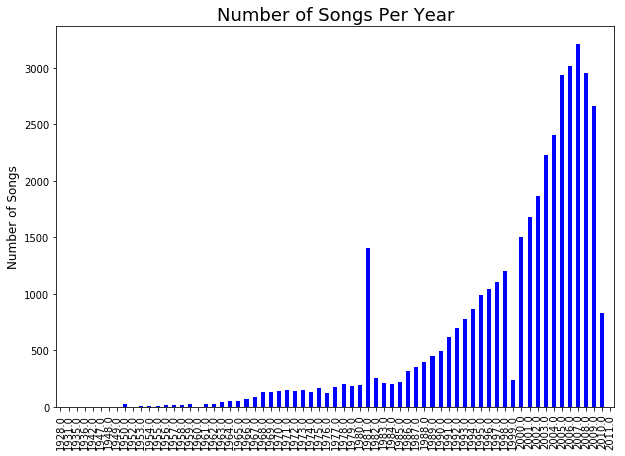

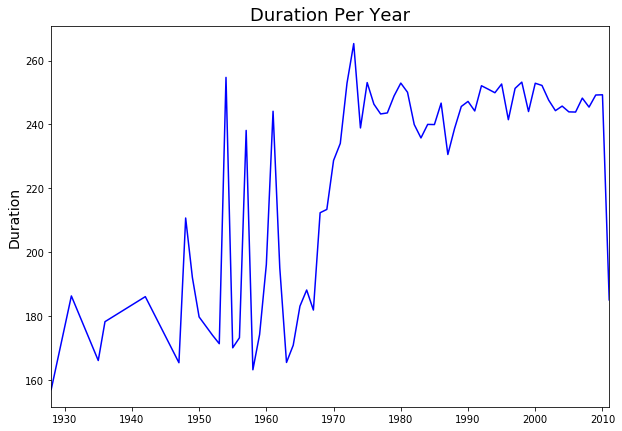

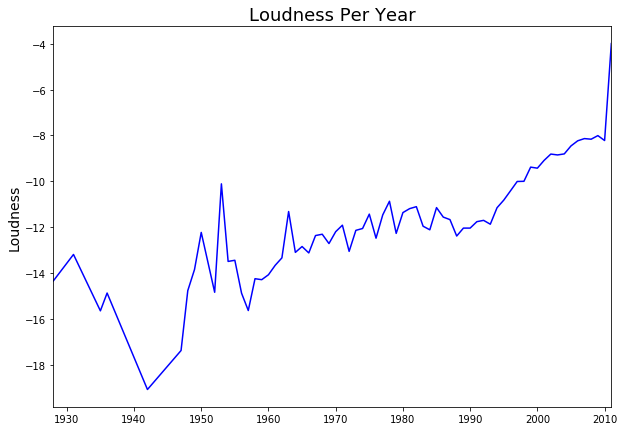

In [278]:
# Play with the data a little

# Number of songs per year
yearSongs = songs.filter( songs["year"] != 0)
count = [item[1] for item in yearSongs.groupBy("year").count().collect()]
year = [item[0] for item in yearSongs.groupBy("year").count().collect()]

numberOfSongsPerYear = {"count":count, "year" : year}
numberOfSongsPerYear = pa.DataFrame(numberOfSongsPerYear)

numberOfSongsPerYear = numberOfSongsPerYear.sort_values(by = "year")
numberOfSongsPerYear.plot(figsize = (10,7), kind = "bar", color = "blue", x = "year", y = "count", legend = False)
plt.xlabel("", fontsize = 12)
plt.ylabel("Number of Songs", fontsize = 12)
plt.title("Number of Songs Per Year", fontsize = 18)
#plt.xticks(size = 18)
#plt.yticks(size = 18)
plt.show()

# Duration per year
yearMeans = yearSongs.groupby(yearSongs.year).mean()
duration = [item[7] for item in yearMeans.collect()]

durationOfSongsPerYear = {"duration":duration, "year" : year}
durationOfSongsPerYear = pa.DataFrame(durationOfSongsPerYear)

durationOfSongsPerYear = durationOfSongsPerYear.sort_values(by = "year")
durationOfSongsPerYear.plot(figsize = (10,7), kind = "line", color = "blue", x = "year", y = "duration", legend = False)
plt.xlabel("", fontsize = 14)
plt.ylabel("Duration", fontsize = 14)
plt.title("Duration Per Year", fontsize = 18)
plt.show()

# Loudness per year
loudness = [item[10] for item in yearMeans.collect()]

loudnessOfSongsPerYear = {"loudness":loudness, "year" : year}
loudnessOfSongsPerYear = pa.DataFrame(loudnessOfSongsPerYear)

loudnessOfSongsPerYear = loudnessOfSongsPerYear.sort_values(by = "year")
loudnessOfSongsPerYear.plot(figsize = (10,7), kind = "line", color = "blue", x = "year", y = "loudness", legend = False)
plt.xlabel("", fontsize = 14)
plt.ylabel("Loudness", fontsize = 14)
plt.title("Loudness Per Year", fontsize = 18)
plt.show()


In [279]:
songHotnessMean = songs.agg({"songHotttnesss": "avg"}).collect()[0][0]
print( songHotnessMean )

# Add a new column called Popular being 1 or 0, based on songHotttnesss being bigger than average or not.
from pyspark.sql.functions import udf
def mapPopular(songHotness):
    if songHotness >= songHotnessMean:
        return 1
    else:
        return 0
    
popularCol = udf(mapPopular, IntegerType())
songs = songs.withColumn('popular', popularCol('songHotttnesss') )
songs.select('popular').show()

songs.groupBy('popular').count().show()

0.35597475022952535
+-------+
|popular|
+-------+
|      0|
|      0|
|      1|
|      0|
|      1|
|      1|
|      1|
|      0|
|      0|
|      1|
|      0|
|      0|
|      1|
|      0|
|      1|
|      0|
|      0|
|      0|
|      1|
|      1|
+-------+
only showing top 20 rows

+-------+-----+
|popular|count|
+-------+-----+
|      1|35596|
|      0|30993|
+-------+-----+



In [280]:
# Try training
from pyspark.ml.feature import StringIndexer

# Drop string columns which are not supported.
songs = songs.drop('artistLocation')
songs = songs.drop('title')
songs = songs.drop('songId')

# Preparing feature variables.
column_names = songs.columns[0:]
print( column_names )

categoricalColumns = column_names
indexers = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"_Index", handleInvalid="keep")
    indexers += [stringIndexer]
    
models = []
for model in indexers:
    indexer_model = model.fit(songs)
    models += [indexer_model]
    
for i in models:
    songs = i.transform(songs)
    
songs.columns

['artistName', 'artistFamiliarity', 'artistHottness', 'artistLatitude', 'artistLongitude', 'songHotttnesss', 'danceability', 'duration', 'energy', 'key', 'loudness', 'mode', 'tempo', 'year', 'popular']


['artistName',
 'artistFamiliarity',
 'artistHottness',
 'artistLatitude',
 'artistLongitude',
 'songHotttnesss',
 'danceability',
 'duration',
 'energy',
 'key',
 'loudness',
 'mode',
 'tempo',
 'year',
 'popular',
 'artistName_Index',
 'artistFamiliarity_Index',
 'artistHottness_Index',
 'artistLatitude_Index',
 'artistLongitude_Index',
 'songHotttnesss_Index',
 'danceability_Index',
 'duration_Index',
 'energy_Index',
 'key_Index',
 'loudness_Index',
 'mode_Index',
 'tempo_Index',
 'year_Index',
 'popular_Index']

In [281]:
# Applying the model.
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

features = songs.columns[1:]
feature_vectors = VectorAssembler(inputCols = features, outputCol = "features")

songs = feature_vectors.transform(songs)
songs.columns

# Logistic Regression
# Split dataset into training and testing data.
(trainDF, testDF) = songs.randomSplit( [0.75, 0.25], seed = 12345 )

# Create the classfie and train the model.
lr = LogisticRegression(labelCol="popular", featuresCol="features", maxIter=10)
lrModel = lr.fit(trainDF)


In [282]:
# Run test data.
predicted = lrModel.transform(testDF)
predicted.printSchema()

root
 |-- artistName: string (nullable = true)
 |-- artistFamiliarity: double (nullable = true)
 |-- artistHottness: double (nullable = true)
 |-- artistLatitude: double (nullable = true)
 |-- artistLongitude: double (nullable = true)
 |-- songHotttnesss: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- year: double (nullable = true)
 |-- popular: integer (nullable = true)
 |-- artistName_Index: double (nullable = false)
 |-- artistFamiliarity_Index: double (nullable = false)
 |-- artistHottness_Index: double (nullable = false)
 |-- artistLatitude_Index: double (nullable = false)
 |-- artistLongitude_Index: double (nullable = false)
 |-- songHotttnesss_Index: double (nullable = false)
 |-- danceability_Index: double (nullable = false)
 |--

In [283]:
# Display new added columns by the classifier.
predicted.select(['songHotttnesss', 'rawPrediction', 'probability', 'prediction']).show()

+-------------------+--------------------+--------------------+----------+
|     songHotttnesss|       rawPrediction|         probability|prediction|
+-------------------+--------------------+--------------------+----------+
| 0.7955096364021301|[-10.562008877892...|[2.58801379398993...|       1.0|
| 0.3759843111038208|[-4.8511428257019...|[0.00775876700484...|       1.0|
|                0.0|[9.26851135108812...|[0.99990566003918...|       0.0|
|0.39690521359443665|[-6.1206645573446...|[0.00219217924052...|       1.0|
| 0.3107915222644806|[7.29715222599207...|[0.99932299334970...|       0.0|
|                0.0|[7.51746208718813...|[0.99945678504442...|       0.0|
| 0.3829350769519806|[-6.1767224524752...|[0.00207291899410...|       1.0|
| 0.2669551968574524|[5.81777151031732...|[0.99703459399053...|       0.0|
|                0.0|[8.73192798581410...|[0.99983867495639...|       0.0|
|0.21508032083511353|[7.25200972000713...|[0.99929175339837...|       0.0|
| 0.5684947371482849|[-7.

In [284]:
# Verifiy model
predicted.crosstab('popular', 'prediction').show()

from sklearn import metrics
pactual = predicted.select('popular').toPandas()
ppredicted = predicted.select('prediction').toPandas()

metrics.accuracy_score(pactual, ppredicted)

+------------------+----+----+
|popular_prediction| 0.0| 1.0|
+------------------+----+----+
|                 1|   0|8914|
|                 0|7856|   0|
+------------------+----+----+



1.0

In [285]:
endTime = time.time()
print( "Processed %d songs in %0.6f seconds." % (totalSongs, endTime - startTime) )

# release the cores for another application!
spark_context.stop()

Processed 115976 songs in 6817.472306 seconds.
